Imports

In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, SelectFromModel
import joblib
from typing import Tuple
import warnings
from scipy import stats
from scipy.fft import fft
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

Data Loading and Batching

In [13]:
class DataLoader:
    def __init__(self, train_split=0.7, random_state=43, batch_size=32):
        self.train_split = train_split
        self.random_state = random_state
        self.batch_size = batch_size
        self.all_data = None
        self.all_labels = None
        self.file_metadata = None
        self.train_files = None
        self.test_files = None
        self.train_batches = None
        self.test_batches = None
        self.train_batch_labels = None
        self.test_batch_labels = None

    def load_all_data(self, train_dir: str, test_dir: str) -> None:
        all_file_data = {}
        
        for directory, dir_type in [(train_dir, 'original_train'), (test_dir, 'original_test')]:
            if not os.path.exists(directory):
                continue

            for folder in sorted(os.listdir(directory)):
                folder_path = os.path.join(directory, folder)
                if not os.path.isdir(folder_path):
                    continue

                for file in os.listdir(folder_path):
                    if not file.endswith('.csv'):
                        continue

                    file_path = os.path.join(folder_path, file)
                    df = pd.read_csv(file_path, encoding="ISO-8859-1")
                    file_id = f"{dir_type}_{folder}_{file.replace('.csv', '')}"
                    
                    all_file_data[file_id] = {
                        'data': df,
                        'label': folder,
                        'file_path': file_path,
                        'original_source': dir_type,
                        'activity': folder
                    }

        self.file_metadata = all_file_data
        print(f"Total files: {len(self.file_metadata)}")
        print(f"Activities: {sorted(set([meta['activity'] for meta in self.file_metadata.values()]))}")
        
        self._analyze_file_distribution()
        self._create_batches()

    def _analyze_file_distribution(self):
        print("\nFile distribution per activity:")
        activity_stats = {}
        
        for file_id, meta in self.file_metadata.items():
            activity = meta['activity']
            if activity not in activity_stats:
                activity_stats[activity] = {'files': 0, 'total_samples': 0}
            
            activity_stats[activity]['files'] += 1
            activity_stats[activity]['total_samples'] += len(meta['data'])
        
        for activity in sorted(activity_stats.keys()):
            stats = activity_stats[activity]
            print(f"{activity}: {stats['files']} files, {stats['total_samples']} samples")
        
        total_files = sum([stats['files'] for stats in activity_stats.values()])
        total_samples = sum([stats['total_samples'] for stats in activity_stats.values()])
        print(f"Total: {total_files} files, {total_samples} samples")

    def _create_batches(self):
        print(f"\nCreating batches with batch_size={self.batch_size}")
        
        all_batches = []
        all_batch_labels = []
        batch_file_mapping = []
        
        for file_id, meta in self.file_metadata.items():
            df = meta['data'].copy()
            label = meta['label']
            
            feature_cols = [col for col in df.columns if col not in ['label', 'Unnamed: 0', 'time']]
            features = df[feature_cols].dropna()
            
            if len(features) == 0:
                continue
            
            n_complete_batches = len(features) // self.batch_size
            
            if n_complete_batches == 0:
                print(f"File {file_id}: {len(features)} samples - No complete batches (skipped)")
                continue
            
            print(f"File {file_id}: {len(features)} samples -> {n_complete_batches} batches")
            
            for batch_idx in range(n_complete_batches):
                start_idx = batch_idx * self.batch_size
                end_idx = start_idx + self.batch_size
                
                batch_data = features.iloc[start_idx:end_idx].values
                aggregated_batch = np.mean(batch_data, axis=0)
                
                all_batches.append(aggregated_batch)
                all_batch_labels.append(label)
                batch_file_mapping.append(file_id)
        
        self.all_batches = np.array(all_batches)
        self.all_batch_labels = np.array(all_batch_labels)
        self.batch_file_mapping = batch_file_mapping
        
        print(f"\nTotal batches created: {len(self.all_batches)}")
        print(f"Batch feature dimension: {self.all_batches.shape[1] if len(self.all_batches) > 0 else 0}")

    def split_by_files(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        if self.all_batches is None or len(self.all_batches) == 0:
            raise ValueError("No batches created. Check if data was loaded properly.")

        all_files = list(self.file_metadata.keys())
        np.random.seed(self.random_state)
        np.random.shuffle(all_files)

        n_train_files = int(len(all_files) * self.train_split)
        self.train_files = all_files[:n_train_files]
        self.test_files = all_files[n_train_files:]

        print(f"\nTrain files: {len(self.train_files)}")
        print(f"Test files: {len(self.test_files)}")

        train_indices = [i for i, file_id in enumerate(self.batch_file_mapping) if file_id in self.train_files]
        test_indices = [i for i, file_id in enumerate(self.batch_file_mapping) if file_id in self.test_files]

        X_train = self.all_batches[train_indices]
        X_test = self.all_batches[test_indices]
        y_train = self.all_batch_labels[train_indices]
        y_test = self.all_batch_labels[test_indices]

        self.train_batches = X_train
        self.test_batches = X_test
        self.train_batch_labels = y_train
        self.test_batch_labels = y_test

        print(f"Train batches: {len(X_train)}")
        print(f"Test batches: {len(X_test)}")

        self._check_activity_distribution_batches(train_indices, test_indices)

        return X_train, X_test, y_train, y_test

    def _check_activity_distribution_batches(self, train_indices, test_indices):
        train_activities = set(self.all_batch_labels[train_indices])
        test_activities = set(self.all_batch_labels[test_indices])
        all_activities = set(self.all_batch_labels)

        print(f"Train activities: {sorted(train_activities)}")
        print(f"Test activities: {sorted(test_activities)}")

        if all_activities - train_activities:
            print(f"Missing in train: {sorted(all_activities - train_activities)}")
        if all_activities - test_activities:
            print(f"Missing in test: {sorted(all_activities - test_activities)}")

        print("\nBatch distribution per activity:")
        for activity in sorted(all_activities):
            train_count = np.sum(self.all_batch_labels[train_indices] == activity)
            test_count = np.sum(self.all_batch_labels[test_indices] == activity)
            print(f"{activity}: {train_count} train batches, {test_count} test batches")

    def load_data(self, root_dir: str) -> Tuple[np.ndarray, np.ndarray]:
        if root_dir.lower() == 'train':
            if self.train_batches is None:
                raise ValueError("Call get_train_test_split first.")
            return self.train_batches, self.train_batch_labels
        elif root_dir.lower() == 'test':
            if self.test_batches is None:
                raise ValueError("Call get_train_test_split first.")
            return self.test_batches, self.test_batch_labels
        else:
            raise ValueError("Invalid root_dir. Use 'train' or 'test'.")

    def get_train_test_split(self, train_dir: str = 'train', test_dir: str = 'test') -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        self.load_all_data(train_dir, test_dir)
        return self.split_by_files()

loader = DataLoader(train_split=0.8, random_state=43, batch_size=32)
X_train_batches, X_test_batches, y_train_batches, y_test_batches = loader.get_train_test_split('train', 'test')

print(f"\nFinal Results:")
print(f"Train batches shape: {X_train_batches.shape}")
print(f"Test batches shape: {X_test_batches.shape}")
print(f"Features per batch: {X_train_batches.shape[1] if len(X_train_batches) > 0 else 0}")
print(f"Classes: {len(np.unique(y_train_batches)) if len(y_train_batches) > 0 else 0}")

Total files: 170
Activities: ['idle', 'with_hook_climbing_up', 'with_hook_descending_down', 'without_hook_climbing_up', 'without_hook_descending_down']

File distribution per activity:
idle: 25 files, 14240 samples
with_hook_climbing_up: 20 files, 11889 samples
with_hook_descending_down: 23 files, 11928 samples
without_hook_climbing_up: 51 files, 11836 samples
without_hook_descending_down: 51 files, 10732 samples
Total: 170 files, 60625 samples

Creating batches with batch_size=32
File original_train_idle_26112024_145604_1: 214 samples -> 6 batches
File original_train_idle_26112024_145637_2: 697 samples -> 21 batches
File original_train_idle_26112024_145733_3: 421 samples -> 13 batches
File original_train_idle_26112024_145818_4: 519 samples -> 16 batches
File original_train_idle_26112024_145857_5: 755 samples -> 23 batches
File original_train_idle_26112024_150001_6: 1442 samples -> 45 batches
File original_train_idle_26112024_150133_7: 1338 samples -> 41 batches
File original_train_idl

Preprocessing

In [14]:
class DataProcessor:
    def __init__(self, random_state: int = 43):
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()

    def fit_transform_train(self, X_train: np.ndarray, y_train: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        print(f"\nProcessing training data:")
        print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

        if np.isnan(X_train).any():
            print("Warning: NaN values found in training data, filling with 0")
            X_train = np.nan_to_num(X_train, 0)

        shuffled_indices = shuffle(range(len(X_train)), random_state=self.random_state)
        X_shuffled = X_train[shuffled_indices]
        y_shuffled = y_train[shuffled_indices]

        y_encoded = self.label_encoder.fit_transform(y_shuffled)
        X_scaled = self.scaler.fit_transform(X_shuffled)
        
        print(f"Processed X_train shape: {X_scaled.shape}")
        print(f"Unique classes: {len(np.unique(y_encoded))}")
        
        return X_scaled, y_shuffled

    def transform_test(self, X_test: np.ndarray, y_test: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        print(f"\nProcessing testing data:")
        print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

        if np.isnan(X_test).any():
            print("Warning: NaN values found in testing data, filling with 0")
            X_test = np.nan_to_num(X_test, 0)

        X_scaled = self.scaler.transform(X_test)
        
        print(f"Processed X_test shape: {X_scaled.shape}")
        
        return X_scaled, y_test

processor = DataProcessor()
if len(X_train_batches) > 0 and len(X_test_batches) > 0:
    X_train_processed, y_train_processed = processor.fit_transform_train(X_train_batches, y_train_batches)
    X_test_processed, y_test_processed = processor.transform_test(X_test_batches, y_test_batches)

    print(f"\nFinal processed shapes:")
    print(f"Processed X_train: {X_train_processed.shape}")
    print(f"Processed X_test: {X_test_processed.shape}")
else:
    print("No batches created - check your data and batch_size parameters")


Processing training data:
X_train shape: (1469, 11), y_train shape: (1469,)
Processed X_train shape: (1469, 11)
Unique classes: 5

Processing testing data:
X_test shape: (345, 11), y_test shape: (345,)
Processed X_test shape: (345, 11)

Final processed shapes:
Processed X_train: (1469, 11)
Processed X_test: (345, 11)


Feature Extraction

In [15]:
def extract_statistical_features(X):
    features = np.column_stack([
        np.mean(X, axis=1), np.std(X, axis=1), np.var(X, axis=1),
        np.median(X, axis=1), np.min(X, axis=1), np.max(X, axis=1),
        np.percentile(X, 25, axis=1), np.percentile(X, 75, axis=1),
        stats.skew(X, axis=1), stats.kurtosis(X, axis=1)
    ])
    return features

def extract_frequency_features(X):
    fft_vals = np.abs(fft(X, axis=1))
    n_half = X.shape[1] // 2
    fft_vals = fft_vals[:, :n_half]
    
    features = np.column_stack([
        np.sum(fft_vals, axis=1), np.mean(fft_vals, axis=1),
        np.std(fft_vals, axis=1), np.max(fft_vals, axis=1)
    ])
    return features

def extract_temporal_features(X):
    zero_crossings = np.sum(np.diff(np.sign(X), axis=1) != 0, axis=1)
    first_diff = np.diff(X, axis=1)
    
    features = np.column_stack([
        zero_crossings,
        np.mean(first_diff, axis=1),
        np.std(first_diff, axis=1),
        np.sum(X**2, axis=1)
    ])
    return features

def extract_all_features(X):
    stat_features = extract_statistical_features(X)
    freq_features = extract_frequency_features(X)
    temp_features = extract_temporal_features(X)
    return np.column_stack([stat_features, freq_features, temp_features])

X_train_features = extract_all_features(X_train_processed)
X_test_features = extract_all_features(X_test_processed)

print(f"Training features extracted: {X_train_features.shape}")
print(f"Test features extracted: {X_test_features.shape}")

X_train_combined = np.column_stack([X_train_processed, X_train_features])
X_test_combined = np.column_stack([X_test_processed, X_test_features])

X_train_combined = np.nan_to_num(X_train_combined, nan=0.0, posinf=1e6, neginf=-1e6)
X_test_combined = np.nan_to_num(X_test_combined, nan=0.0, posinf=1e6, neginf=-1e6)

original_feature_names = ['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'mx', 'my', 'mz', 'p']
stat_feature_names = ['Mean', 'Std', 'Variance', 'Median', 'Min', 'Max', '25th Percentile', '75th Percentile', 'Skewness', 'Kurtosis']
freq_feature_names = ['FFT Sum', 'FFT Mean', 'FFT Std', 'FFT Max']
temp_feature_names = ['Zero Crossings', 'First Diff Mean', 'First Diff Std', 'Signal Energy']

all_feature_names = original_feature_names + stat_feature_names + freq_feature_names + temp_feature_names

print(f"Training features: {X_train_combined.shape}")
print(f"Test features: {X_test_combined.shape}")
for i, name in enumerate(all_feature_names):
    print(f"{i:2d}: {name}")

Training features extracted: (1469, 18)
Test features extracted: (345, 18)
Training features: (1469, 29)
Test features: (345, 29)
 0: ax
 1: ay
 2: az
 3: gx
 4: gy
 5: gz
 6: mx
 7: my
 8: mz
 9: p
10: Mean
11: Std
12: Variance
13: Median
14: Min
15: Max
16: 25th Percentile
17: 75th Percentile
18: Skewness
19: Kurtosis
20: FFT Sum
21: FFT Mean
22: FFT Std
23: FFT Max
24: Zero Crossings
25: First Diff Mean
26: First Diff Std
27: Signal Energy


Feature Selection and Scaling

In [16]:
# GRF-based Feature Selection
# Step 1: Train base RF for importance estimation
base_rf = RandomForestClassifier(n_estimators=100, random_state=43, n_jobs=-1)
base_rf.fit(X_train_combined, y_train_processed)
initial_importances = base_rf.feature_importances_

# Step 2: Compute guided importance: λ_i = γ * I_i
gamma = 0.5
guided_importances = gamma * initial_importances

# Step 3: Select features based on importance threshold
threshold = np.median(guided_importances)
selector = SelectFromModel(base_rf, threshold=threshold, prefit=True)

X_train_selected = selector.transform(X_train_combined)
X_test_selected = selector.transform(X_test_combined)
print(f"Features selected: {X_train_selected.shape[1]}")

selected_mask = selector.get_support()
selected_feature_names = [name for i, name in enumerate(all_feature_names) if selected_mask[i]]
print("Selected features:", selected_feature_names)

scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_selected)
X_test_final = scaler.transform(X_test_selected)

Features selected: 27
Selected features: ['ax', 'ay', 'az', 'gy', 'gz', 'mx', 'my', 'mz', 'p', 'Mean', 'Std', 'Variance', 'Median', 'Min', 'Max', '25th Percentile', '75th Percentile', 'Skewness', 'Kurtosis', 'FFT Sum', 'FFT Std', 'FFT Max', 'Zero Crossings', 'First Diff Mean', 'First Diff Std', 'Signal Energy']


Random Forest

In [17]:
model_engineered = RandomForestClassifier(
    n_estimators=10,
    criterion='gini',
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=43,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.01,
    max_samples=None
)

model_engineered.fit(X_train_final, y_train_processed)

RandomForestClassifier(ccp_alpha=0.01, max_depth=5, min_samples_leaf=5,
                       min_samples_split=10, n_estimators=10, n_jobs=-1,
                       random_state=43)

Evaluation and Metrics

In [18]:
y_pred_engineered = model_engineered.predict(X_test_final)
accuracy_engineered = accuracy_score(y_test_processed, y_pred_engineered)
cm_engineered = confusion_matrix(y_test_processed, y_pred_engineered)
classification_rep_engineered = classification_report(y_test_processed, y_pred_engineered, output_dict=True)

print("Engineered Features Model Performance")
print(f"Test Accuracy: {accuracy_engineered:.6f}")
print(f"Test Samples: {len(y_test_processed):,}")

results_df_engineered = pd.DataFrame(classification_rep_engineered).transpose()
print("\nClassification Report:")
print(results_df_engineered.round(4))

Engineered Features Model Performance
Test Accuracy: 0.997101
Test Samples: 345

Classification Report:
                              precision  recall  f1-score   support
idle                             1.0000  1.0000    1.0000   57.0000
with_hook_climbing_up            1.0000  1.0000    1.0000   88.0000
with_hook_descending_down        0.9836  1.0000    0.9917   60.0000
without_hook_climbing_up         1.0000  0.9861    0.9930   72.0000
without_hook_descending_down     1.0000  1.0000    1.0000   68.0000
accuracy                         0.9971  0.9971    0.9971    0.9971
macro avg                        0.9967  0.9972    0.9969  345.0000
weighted avg                     0.9971  0.9971    0.9971  345.0000


Logistic Regression

In [19]:
# def extract_statistical_features(X):
#     features = np.column_stack([
#         np.mean(X, axis=1), np.std(X, axis=1), np.var(X, axis=1),
#         np.median(X, axis=1), np.min(X, axis=1), np.max(X, axis=1),
#         np.percentile(X, 25, axis=1), np.percentile(X, 75, axis=1),
#         stats.skew(X, axis=1), stats.kurtosis(X, axis=1)
#     ])
#     return features

# def extract_frequency_features(X):
#     fft_vals = np.abs(fft(X, axis=1))
#     n_half = X.shape[1] // 2
#     fft_vals = fft_vals[:, :n_half]
    
#     features = np.column_stack([
#         np.sum(fft_vals, axis=1), np.mean(fft_vals, axis=1),
#         np.std(fft_vals, axis=1), np.max(fft_vals, axis=1)
#     ])
#     return features

# def extract_temporal_features(X):
#     zero_crossings = np.sum(np.diff(np.sign(X), axis=1) != 0, axis=1)
#     first_diff = np.diff(X, axis=1)
    
#     features = np.column_stack([
#         zero_crossings,
#         np.mean(first_diff, axis=1),
#         np.std(first_diff, axis=1),
#         np.sum(X**2, axis=1)
#     ])
#     return features

# def extract_all_features(X):
#     stat_features = extract_statistical_features(X)
#     freq_features = extract_frequency_features(X)
#     temp_features = extract_temporal_features(X)
#     return np.column_stack([stat_features, freq_features, temp_features])

# X_train_features = extract_all_features(X_train_processed)
# X_test_features = extract_all_features(X_test_processed)

# print(f"Training features extracted: {X_train_features.shape}")
# print(f"Test features extracted: {X_test_features.shape}")

# X_train_combined = np.column_stack([X_train_processed, X_train_features])
# X_test_combined = np.column_stack([X_test_processed, X_test_features])

# X_train_combined = np.nan_to_num(X_train_combined, nan=0.0, posinf=1e6, neginf=-1e6)
# X_test_combined = np.nan_to_num(X_test_combined, nan=0.0, posinf=1e6, neginf=-1e6)

# original_feature_names = ['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'mx', 'my', 'mz', 'p']
# stat_feature_names = ['Mean', 'Std', 'Variance', 'Median', 'Min', 'Max', '25th Percentile', '75th Percentile', 'Skewness', 'Kurtosis']
# freq_feature_names = ['FFT Sum', 'FFT Mean', 'FFT Std', 'FFT Max']
# temp_feature_names = ['Zero Crossings', 'First Diff Mean', 'First Diff Std', 'Signal Energy']

# all_feature_names = original_feature_names + stat_feature_names + freq_feature_names + temp_feature_names

# print(f"Training features: {X_train_combined.shape}")
# print(f"Test features: {X_test_combined.shape}")
# for i, name in enumerate(all_feature_names):
#     print(f"{i:2d}: {name}")

# selector = SelectKBest(mutual_info_classif, k=10)
# X_train_selected = selector.fit_transform(X_train_combined, y_train_processed)
# X_test_selected = selector.transform(X_test_combined)

# scaler = StandardScaler()
# X_train_final = scaler.fit_transform(X_train_selected)
# X_test_final = scaler.transform(X_test_selected)


# model = LogisticRegression(
#     penalty='l1', dual=False, tol=1e-3, C=0.089, fit_intercept=True,
#     intercept_scaling=0.80, solver='saga', max_iter=100,
#     multi_class='multinomial', random_state=43, n_jobs=-1
# )

# model.fit(X_train_final, y_train_processed)

# y_pred_engineered = model.predict(X_test_final)
# accuracy_engineered = accuracy_score(y_test_processed, y_pred_engineered)
# cm_engineered = confusion_matrix(y_test_processed, y_pred_engineered)
# classification_rep_engineered = classification_report(y_test_processed, y_pred_engineered, output_dict=True)

# print("Engineered Features Model Performance")
# print(f"Test Accuracy: {accuracy_engineered:.6f}")
# print(f"Test Samples: {len(y_test_processed):,}")

# results_df_engineered = pd.DataFrame(classification_rep_engineered).transpose()
# print("\nClassification Report:")
# print(results_df_engineered.round(4))

Visualization

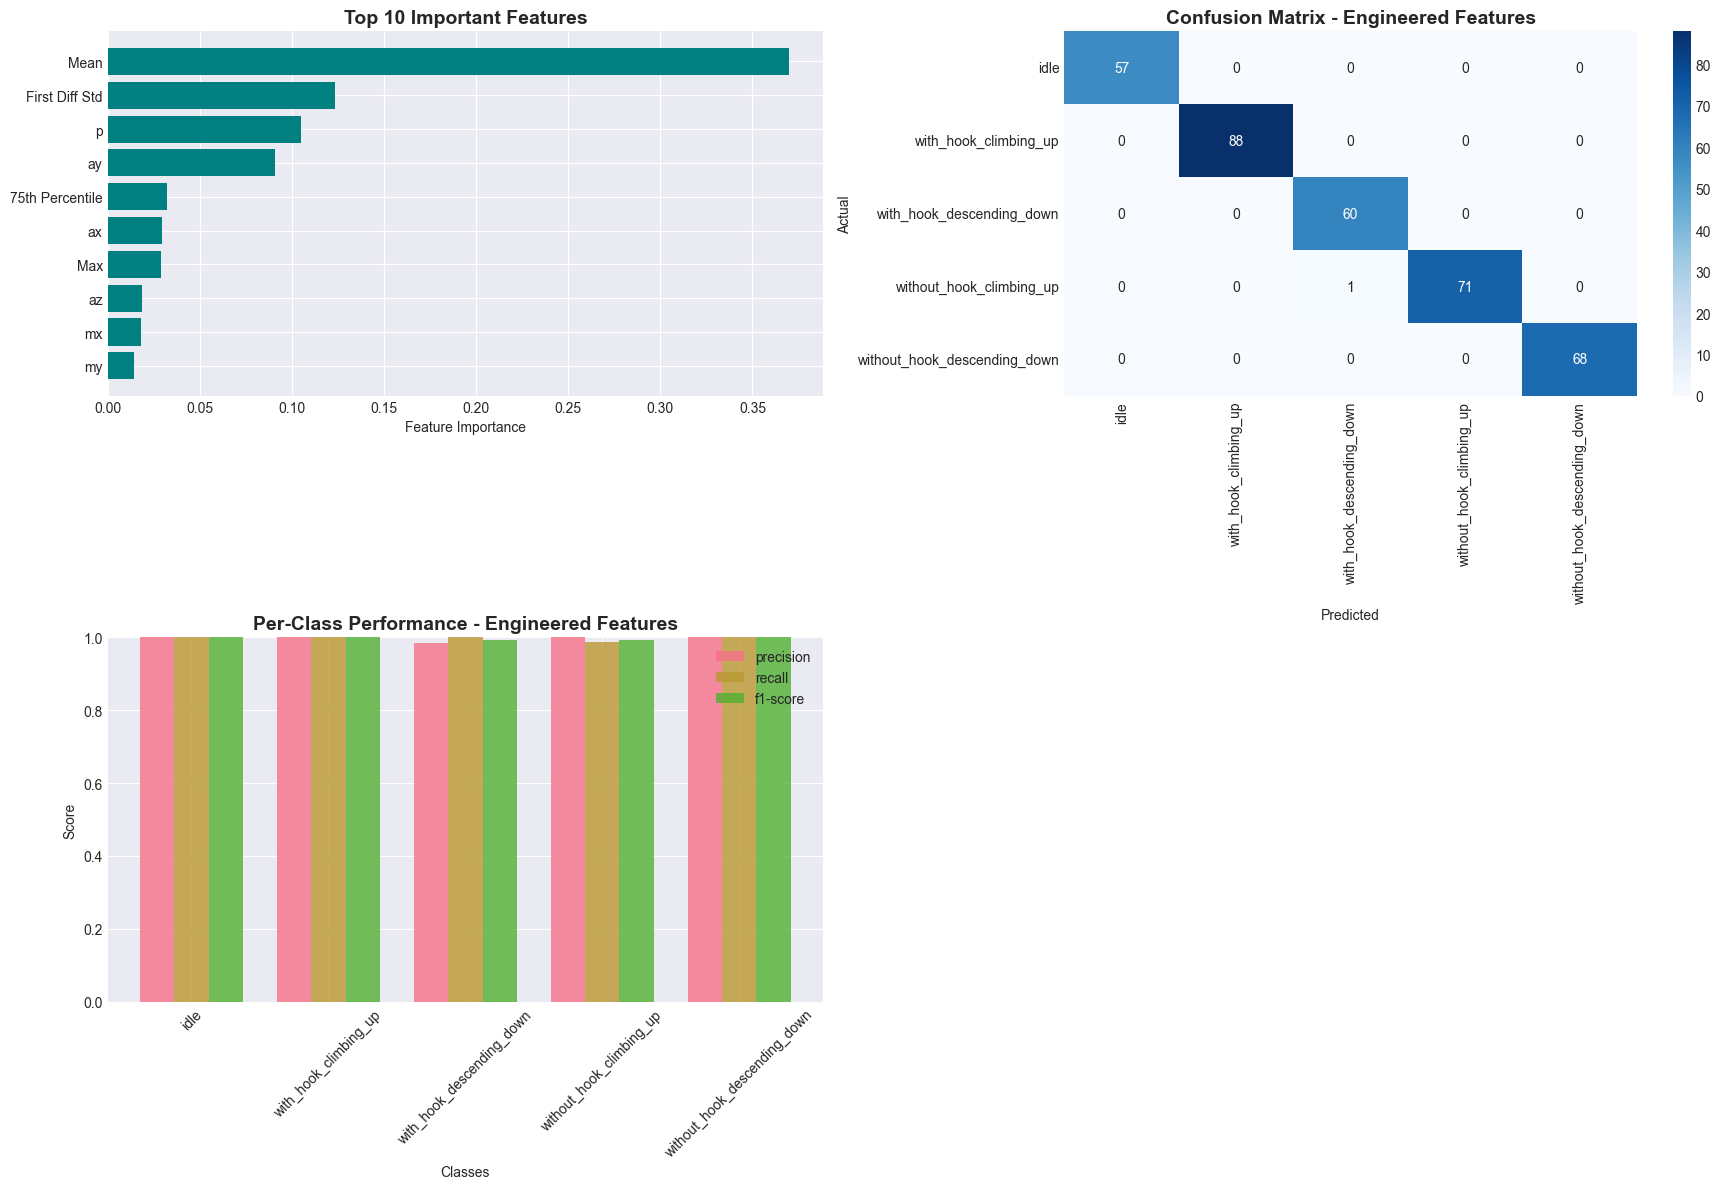

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Top 10 Selected Features
top_10_idx = np.argsort(initial_importances)[-10:][::-1]
top_10_scores = initial_importances[top_10_idx]
top_10_names = [all_feature_names[i] for i in top_10_idx]

y_pos = np.arange(len(top_10_scores))
axes[0, 0].barh(y_pos, top_10_scores, color='teal')
axes[0, 0].set_yticks(y_pos)
axes[0, 0].set_yticklabels(top_10_names)
axes[0, 0].invert_yaxis()  # Most important feature on top
axes[0, 0].set_xlabel('Feature Importance')
axes[0, 0].set_title('Top 10 Important Features', fontsize=14, fontweight='bold')

# Confusion Matrix
sns.heatmap(cm_engineered, annot=True, fmt='d', cmap='Blues',
            xticklabels=model_engineered.classes_,
            yticklabels=model_engineered.classes_,
            ax=axes[0, 1])
axes[0, 1].set_title('Confusion Matrix - Engineered Features', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')

# Per-Class Performance Bar Chart
metrics = ['precision', 'recall', 'f1-score']
classes = [c for c in results_df_engineered.index if c not in ['accuracy', 'macro avg', 'weighted avg']]
x_pos = np.arange(len(classes))

for i, metric in enumerate(metrics):
    values = [results_df_engineered.loc[c, metric] for c in classes]
    axes[1, 0].bar(x_pos + i*0.25, values, width=0.25, label=metric, alpha=0.8)

axes[1, 0].set_xlabel('Classes')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Per-Class Performance - Engineered Features', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x_pos + 0.25)
axes[1, 0].set_xticklabels(classes, rotation=45)
axes[1, 0].legend()
axes[1, 0].set_ylim(0, 1)

fig.delaxes(axes[1, 1])

plt.tight_layout()
plt.show()

Saving Files

In [21]:
joblib.dump(model_engineered, "model.pkl")
joblib.dump(processor.scaler, "scaler.pkl")
joblib.dump(processor.label_encoder, "label_encoder.pkl")
model_size_kb = os.path.getsize("model.pkl") / 1024

print(f"Engineered Model Size: {model_size_kb:.2f} KB")

Engineered Model Size: 27.02 KB
